# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre - Processing

In [3]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [4]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [5]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [6]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [7]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
scores = final['Score']

# Split the Data Set into train and test

In [10]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
from sklearn.preprocessing import Imputer
# =============================================================================================
#supress warnings
warnings.filterwarnings("ignore")
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_1 = y_1.values


# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

#tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit(X_tr)
X_tr_vector = final_tf_idf.transform(X_tr)
X_cv_vector = final_tf_idf.transform(X_cv)
X_test_vector = final_tf_idf.transform(X_test)


# CV Accuracy

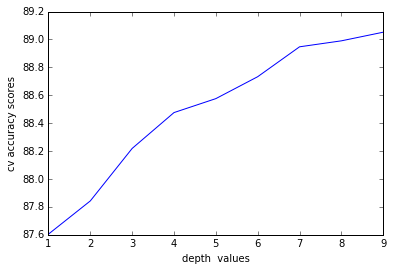

In [14]:
from sklearn import tree
cv_scores =[]
k_values = []
for i in range(1,10,1):
    # instantiate learning model (max_depth = 10)
    dt =tree.DecisionTreeClassifier(max_depth=i)
    
    # fitting the model on crossvalidation train
    dt.fit(X_tr_vector, y_tr)

    # predict the response on the crossvalidation train
    pred = dt.predict(X_cv_vector)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    k_values.append(i)
plt.plot(k_values, cv_scores)
plt.xlabel('depth  values')
plt.ylabel('cv accuracy scores')
plt.show()

# Finding Optimal depth of tree


The optimal number of neighbors is 9.


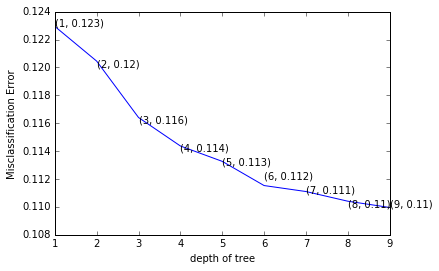

the misclassification error for each depth :  [0.123 0.12  0.116 0.114 0.113 0.112 0.111 0.11  0.11 ]


In [15]:
depth = list(range(1,10))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in depth:
    dt =tree.DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(dt, X_tr_vector, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_depth = depth[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_depth)

# plot misclassification error vs k 
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('depth of tree')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth : ", np.round(MSE,3))

# CV Accuarcy using Optimal depth

In [16]:
# ============================== DecisionTeeClasssifier with optimal_depth===============================================
# instantiate learning model eith optimal depth
dt_optimal = tree.DecisionTreeClassifier(max_depth=optimal_depth)

# fitting the model
dt_optimal.fit(X_tr_vector, y_tr)

# predict the response on CV
pred = dt_optimal.predict(X_cv_vector)

 # evaluate CV accuracy
acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
print('\nThe CV accuracy of the DecisionTreeClassifier for depth = %d is %f%%' % (optimal_depth, acc))


The CV accuracy of the DecisionTreeClassifier for depth = 9 is 88.995238%


# Train & Test Accuracy using Optimal depth

In [17]:
# ============================== DecisionTeeClasssifier with optimal_depth===============================================
# instantiate learning model eith optimal depth
dt_optimal = tree.DecisionTreeClassifier(max_depth=optimal_depth)

# fitting the model
dt_optimal.fit(X_tr_vector, y_tr)

# predict the response on CV
pred = dt_optimal.predict(X_test_vector)

 # evaluate CV accuracy
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\nThe Test accuracy of the DecisionTreeClassifier for depth = %d is %f%%' % (optimal_depth, acc))
trainacc = dt_optimal.score(X_tr_vector, y_tr)
print('\nThe Train accuracy of the DecisionTreeClassifier for depth = %d is %f%%' % (optimal_depth, trainacc*100))


The Test accuracy of the DecisionTreeClassifier for depth = 9 is 89.280000%

The Train accuracy of the DecisionTreeClassifier for depth = 9 is 89.975510%


# Important Features

In [18]:
importances = dt_optimal.feature_importances_
feature_names =tf_idf_vect.get_feature_names()
imp = sorted(zip(importances, feature_names),reverse=True)[:20]
for imortance,feature in imp:
    print(imortance,feature)

0.1538597448021171 disappoint
0.11186748555506422 wast money
0.09773291592770768 worst
0.08597465020248422 great
0.07830643092890122 horribl
0.06629808560390614 return
0.054972636275708246 terribl
0.05274732648703891 threw
0.0514237422529427 refund
0.031055396422478634 wont disappoint
0.02327329062519542 best
0.017917620293376235 delici
0.012869823106485894 love
0.010419493717785088 never disappoint
0.007343245492367996 ive
0.006295960695263054 great review
0.005653745354307003 high recommend
0.005574249184750438 found
0.005339840757309238 add
0.004153453964402869 food


# Conclusion

In [9]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Model', 'Hyperparameter','CV Error','Train Error','Test Error']
t.add_row(["DT using BOW vectorizer","9","0.11004762","0.1002449","0.1072"])
print(t)

+-------------------------+----------------+------------+-------------+------------+
|          Model          | Hyperparameter |  CV Error  | Train Error | Test Error |
+-------------------------+----------------+------------+-------------+------------+
| DT using BOW vectorizer |       9        | 0.11004762 |  0.1002449  |   0.1072   |
+-------------------------+----------------+------------+-------------+------------+
